In [3]:
# Import TensorFlow and Keras modules
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input, Dropout, Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
# 🚀 Step 2: Define Dataset Paths
base_dir = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [21]:
# 🚀 Step 3: Load Data Using ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [22]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [23]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 34792 images belonging to 5 classes.


In [24]:
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 9940 images belonging to 5 classes.


In [77]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4971 images belonging to 5 classes.


In [26]:
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers except the last 10
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Define input
inputs = Input(shape=(224, 224, 3))

# Pass input through base model
x = base_model(inputs, training=False)

# Additional layers
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)

x = Dense(256, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Output layer
outputs = Dense(5, activation='softmax')(x)

# Final model
model = Model(inputs, outputs)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,462,277 (322.20 MB)

 Trainable params: 41,163,141 (157.02 MB)

 Non-trainable params: 43,299,136 (165.17 MB)

In [30]:
model.compile(optimizer = Adam,
             loss='categorical_crossentropy',
             metrics = ['accuracy'])

In [15]:
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True, verbose=1, mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Combine Callbacks
callbacks = [checkpoint, reduce_lr, early_stop]

In [28]:
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size

In [29]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

543
155


In [182]:
history = model.fit(
    train_data,
    steps_per_epoch=100,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    validation_steps=20
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 876ms/step - accuracy: 0.8421 - loss: 0.3991 - val_accuracy: 0.7789 - val_loss: 0.5498
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 862ms/step - accuracy: 0.8509 - loss: 0.3885 - val_accuracy: 0.7742 - val_loss: 0.5397
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 872ms/step - accuracy: 0.8470 - loss: 0.3925 - val_accuracy: 0.7758 - val_loss: 0.6074
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 845ms/step - accuracy: 0.8549 - loss: 0.3807 - val_accuracy: 0.7727 - val_loss: 0.5914
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 825ms/step - accuracy: 0.8523 - loss: 0.3747 - val_accuracy: 0.7641 - val_loss: 0.6130


In [183]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.7009 - loss: 0.7940
Test Accuracy: 0.7724803686141968


In [177]:
import numpy as np

pred_probs = model.predict(test_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes


78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step


In [178]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.57      0.76      0.65      1000
           1       0.78      0.67      0.72       971
           2       0.66      0.56      0.61      1000
           3       0.97      0.94      0.96      1000
           4       0.99      0.97      0.98      1000

    accuracy                           0.78      4971
   macro avg       0.80      0.78      0.78      4971
weighted avg       0.80      0.78      0.79      4971



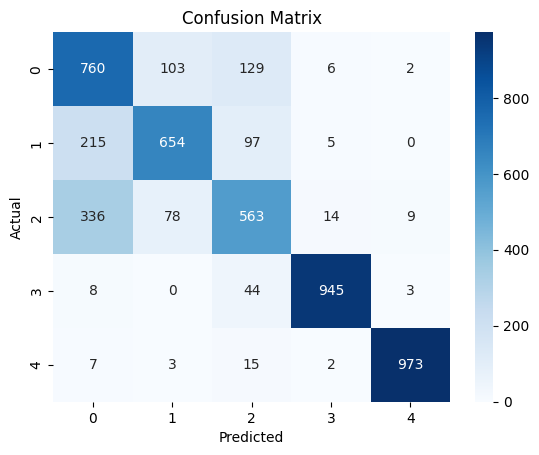

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [180]:
# Extract loss and accuracy from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']  # For classification
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)  # Number of epochs


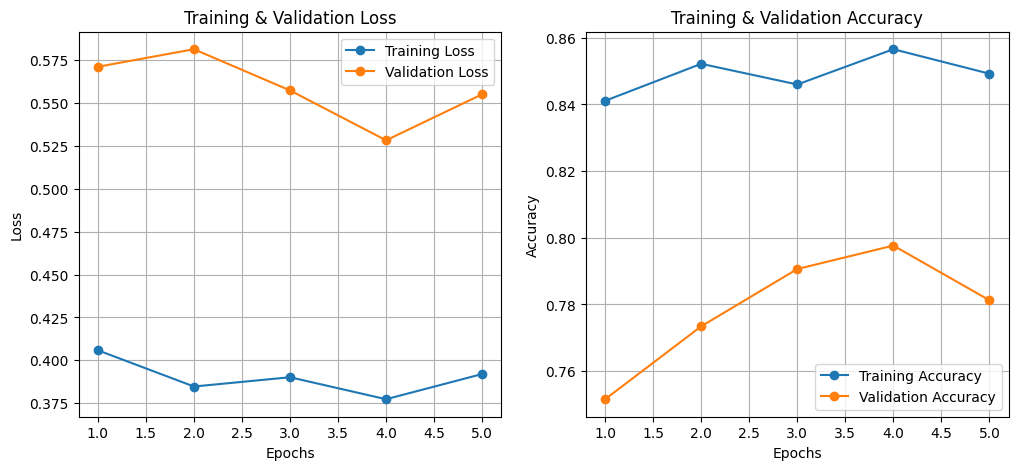

In [181]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()

plt.show()


In [172]:
# Save the model to an .h5 file
model.save('model.h5')

In [173]:
import shutil
shutil.move('model.h5', '/kaggle/working/model.h5')


'/kaggle/working/model.h5'

In [174]:
from IPython.display import FileLink

# Create a clickable download link for your .h5 model
FileLink(r'model.h5')


/kaggle/working/model.h5

In [80]:
from tensorflow.keras.preprocessing import image

img_path = '/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/0/10013_left.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalize if needed


In [142]:
import cv2  # for image processing

def get_img_array(img_path, size):
    """Loads and preprocesses the image."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # match your training preprocessing
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Computes the Grad-CAM heatmap.
    
    Args:
        img_array: Preprocessed image in shape (1, height, width, channels).
        model: The full model.
        last_conv_layer_name: Name of the last convolutional layer.
        pred_index: Index of the target class. If None, use the predicted class.
    Returns:
        heatmap: A 2D numpy array of the Grad-CAM heatmap.
    """
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class (or specified index)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Get gradients of the target class wrt the convolutional output
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the convolution outputs with the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays the heatmap onto the original image.
    """
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # Convert the heatmap to RGB using the colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Superimpose the heatmap on the image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Example usage:
img_path = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test/0/10013_left.jpeg"  # change this to your image path
img_array = get_img_array(img_path, size=(224, 224))
# Ensure that 'conv5_block3_out' exists in your model
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="resnet152v2")
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()

# Overlay and display the heatmap on the original image
superimposed_img = overlay_heatmap(img_path, heatmap)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Overlayed Grad-CAM")
plt.axis('off')
plt.show()


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m135537111197120\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         ...,\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5176471, 0.5176471, 0.5176471],\n         [0.5019608, 0.5019608, 0.5019608]],\n\n        [[0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         ...,\n         [0.5058824, 0.5058824, 0.5058824],\n         [0.5176471, 0.5176471, 0.5176471],\n         [0.5019608, 0.5019608, 0.5019608]],\n\n        [[0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         ...,\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5176471, 0.5176471, 0.5176471],\n         [0.5058824, 0.5058824, 0.5058824]],\n\n        ...,\n\n        [[0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         ...,\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608]],\n\n        [[0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         ...,\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5019608, 0.5019608, 0.5019608]],\n\n        [[0.5176471, 0.5176471, 0.5176471],\n         [0.5137255, 0.5137255, 0.5137255],\n         [0.5019608, 0.5019608, 0.5019608],\n         ...,\n         [0.5019608, 0.5019608, 0.5019608],\n         [0.5137255, 0.5137255, 0.5137255],\n         [0.5176471, 0.5176471, 0.5176471]]]], dtype=float32)\n  • training=None\n  • mask=None'

In [55]:
import sys
import tensorflow as tf
print("Python version:", sys.version)

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
TensorFlow version: 2.17.1
